In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
f_train = '/Users/mflynn/Downloads/EMNIST/emnist/emnist-balanced-train.csv'
f_test  = '/Users/mflynn/Downloads/EMNIST/emnist/emnist-balanced-test.csv'
f_map   = '/Users/mflynn/Downloads/EMNIST/emnist/emnist-balanced-mapping.txt'

In [28]:
train = pd.read_csv(f_train, delimiter = ',')
test = pd.read_csv(f_test, delimiter = ',')
mapp = pd.read_csv(f_map, delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [5]:
# Constants
HEIGHT = 28
WIDTH = 28

In [6]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [7]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [96]:
test.iloc[:,0].max()

46

In [8]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [9]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [10]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

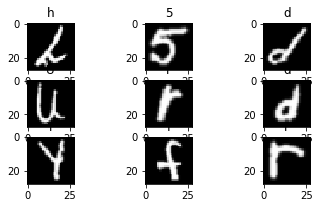

In [11]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))


In [13]:
# number of classes
num_classes = train_y.nunique()
num_classes

47

In [14]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [15]:
train_y[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [18]:
train_x.shape

(112799, 28, 28, 1)

In [19]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

In [20]:
# Building model
# ((Si - Fi + 2P)/S) + 1
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)      

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

Instructions for updating:
Use tf.cast instead.
Train on 101519 samples, validate on 11280 samples
Epoch 1/10
101519/101519 [==============================] - 281s 3ms/step - loss: 1.5801 - acc: 0.5527 - val_loss: 0.5648 - val_acc: 0.8132
Epoch 2/10
101519/101519 [==============================] - 279s 3ms/step - loss: 0.7512 - acc: 0.7637 - val_loss: 0.4591 - val_acc: 0.8426
Epoch 3/10
101519/101519 [==============================] - 280s 3ms/step - loss: 0.6213 - acc: 0.7978 - val_loss: 0.4115 - val_acc: 0.8543
Epoch 4/10
101519/101519 [==============================] - 280s 3ms/step - loss: 0.5523 - acc: 0.8190 - val_loss: 0.3877 - val_acc: 0.8621
Epoch 5/10
101519/101519 [==============================] - 522s 5ms/step - loss: 0.5106 - acc: 0.8295 - val_loss: 0.3728 - val_acc: 0.8656
Epoch 6/10
101519/101519 [==============================] - 328s 3ms/step - loss: 0.4803 - acc: 0.8388 - val_loss: 0.3601 - val_acc: 0.8705
Epoch 7/10
101519/101519 [==============================] - 2

In [32]:
history.history['acc']

[0.5526945695199859,
 0.7637289571445506,
 0.7978210975303028,
 0.8190190998447481,
 0.8295392980230941,
 0.8388380499808556,
 0.8452604931384334,
 0.8515056295121484,
 0.8543228361052561,
 0.8584304416209836]

In [31]:
model.save('/Users/mflynn/Repositories/UCIRV201810DATA4/cnnmodel.sav')

In [34]:
results = model.predict(val_x, batch_size=512, verbose=1)

11280/11280 [==============================] - 14s 1ms/step


In [54]:
np.argmax(results, axis=1)

array([29, 29, 14, ..., 10, 42, 30])

In [55]:
np.argmax(val_y, axis=1)

array([29, 46, 14, ..., 10, 42, 30])

In [57]:
np.sum(np.argmax(results, axis=1) == np.argmax(val_y, axis=1))

9907

In [58]:
np.shape(val_y)

(11280, 47)

In [59]:
9907/11280

0.8782801418439716

In [61]:
from keras.models import load_model
ldmodel = load_model('/Users/mflynn/Repositories/UCIRV201810DATA4/cnnmodel.sav')

In [62]:
rtmp = ldmodel.predict(val_x, batch_size=512, verbose=1)

11280/11280 [==============================] - 13s 1ms/step


In [63]:
np.sum(np.argmax(rtmp, axis=1) == np.argmax(val_y, axis=1))

9907